Here, I test whether my LSTM net works or not to estimate SGM parameters 

Now I run the real data from Parul (Apr 2, 2023)

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [3]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [4]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from models.loss import cos_simi_loss, weighted_mse_loss
from utils.standardize import std_mat, std_vec

In [5]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [6]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc")) # 300/150
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [7]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [8]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

# Train the model

In [9]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net_large", excluding=['opt*'])
sgm_net = trained_model.model;
sgm_net.eval();

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/paras.pkl


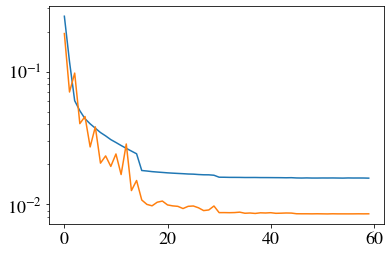

In [10]:
plt.plot(np.array(trained_model.loss)/10)
plt.plot(trained_model.loss_test)
#plt.xticks(np.arange(0, 120, 14));
plt.yscale("log")

In [11]:
# functions to generate training sample (Apr 1, 2023)
def random_choice(n, batchsize=1, len_seg=None):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    if len_seg is None:
        len_seg = torch.randint(low=10, high=100, size=(1, ))
    up_bd = torch.randint(low=len_seg.item(), high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y=None, batchsize=1, 
                       bds=None, 
                       is_std=True, 
                       theta2raw_fn=None):
    """Randomly select a sample from the whole segment
        args:
            X: PSD, num_seq x 68 x nfreq or 
               PSD, num_sub x num_seq x 68 x nfreq
            Y: params, num x 7, in original sgm scale
        return:
            X_seqs: len_seq x batchsize x num_fs
            Y_seqs: len_seq x batchsize x 7
            
    """
    if X.ndim == 4:
        # if multiple subjects, pick up a subject
        num_sub = X.shape[0]
        sub_idx = np.random.randint(low=0, high=num_sub)
        X = X[sub_idx]
        
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if is_std:
        #X = X/X.std(axis=(1, 2), keepdims=True)
        # Let std for each ROI and each data
        X = (X-X.mean(axis=2, keepdims=True))/X.std(axis=2, keepdims=True)
    if Y is not None:
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
        if theta2raw_fn: 
            Y = theta2raw_fn(Y)
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        X_seqs.append(X_seq)
        if Y is not None:
            Y_seq = Y[low_bd:up_bd].unsqueeze(1)
            Y_seqs.append(Y_seq)
    if Y is not None:
        return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)
    else:
        return torch.cat(X_seqs, dim=1)
        

In [12]:
def batch_corr_fn(X_raw, X_pred):
    """Calculate pearons'r in batch
        X_raw: num_p x len_vec
        X_pred: num_p x len_vec
    """
    X_raw_mean = X_raw.mean(axis=-1, keepdims=True)
    X_raw_std = X_raw.std(axis=-1, keepdims=True)
    X_pred_mean = X_pred.mean(axis=-1, keepdims=True)
    X_pred_std = X_pred.std(axis=-1, keepdims=True)
    num = ((X_raw - X_raw_mean)*(X_pred-X_pred_mean)).sum(axis=-1)
    den = torch.sqrt(((X_raw - X_raw_mean)**2).sum(axis=-1)*((X_pred-X_pred_mean)**2).sum(axis=-1))
    corrs = num/den
    return corrs

def evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data).transpose(1, 0)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    Y_pred = rnn(all_data_input);
    X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = batch_corr_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(len_seq, num_sub, -1).transpose(1, 0)
    return corrs.detach().numpy()

In [15]:
paras_rnn = edict()
paras_rnn.batchsize = 128
paras_rnn.niter = 500
paras_rnn.loss_out = 5
paras_rnn.eval_out = 20
paras_rnn.clip = 1 # from 
paras_rnn.lr_step = 10

paras_rnn.k = 1
paras_rnn.hidden_dim = int(1024/1)
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*len(paras.freqs)
paras_rnn.is_bidirectional = False
paras_rnn.dy_mask = [1, 1, 1, 1, 1, 1, 0] 

#  real data, should be len_seq x nrois x nfreqs
data_idx = 0
cur_data = psd_all[:, :, :, 1].transpose(2, 0, 1)
#  real data, should be num_sub x len_seq x nrois x nfreqs
all_data = psd_all.transpose(3, 2, 0, 1);

all_data_raw = torch.tensor(all_data).transpose(1, 0)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);

In [16]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds), 
               k = paras_rnn.k, 
               dy_mask = paras_rnn.dy_mask
)
loss_fn = nn.MSELoss()
loss_fn = weighted_mse_loss
#loss_fn = cos_simi_loss
def loss_fn(X_raw, X_pred):
    return -batch_corr_fn(X_raw, X_pred).mean()

optimizer = torch.optim.AdamW(rnn.parameters(), lr=2e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.


In [ ]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
for ix in range(paras_rnn.niter):
    rnn.train()
    #X_seq = random_samples_rnn(all_data[24], 
    #                           batchsize=paras_rnn.batchsize)
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = rnn(X_seq)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        t0 = time.time()
        
    if ix % paras_rnn.eval_out == (paras_rnn.eval_out-1):
        rnn.eval()
        loss_test = evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


In [ ]:
plt.plot(losses[:])
plt.yscale("log")

# Save

In [ ]:
folder_name = f"LSTM_simu_net_corr";

In [ ]:
if (RES_ROOT/folder_name).exists():
    trained_model = load_pkl_folder2dict(RES_ROOT/folder_name)
else:
    trained_model = edict()
    trained_model.model = rnn
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_rnn
    trained_model.loss = losses
    save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)

# PSD 

In [ ]:
trained_model.model.eval()
sgm_paramss_est = []
for data_idx  in trange(36):
    cur_data = psd_all[:, :, :, data_idx].transpose(2, 0, 1)
    X_test = random_samples_rnn(cur_data,
                                bds=[[0], [360]],
                                theta2raw_fn=None)
    with torch.no_grad():
        Y_pred = trained_model.model(X_test).squeeze()
        sgm_paramss_est.append(Y_pred.numpy())
sgm_paramss_est = np.array(sgm_paramss_est);

trained_model.sgm_paramss_est = sgm_paramss_est
save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)

In [ ]:
# calculate rec PSD and save, only need once
import multiprocessing as mp
num_core = 20

sgmmodel = SGM(paras.C, paras.D, paras.freqs)
def fn(sgm_param):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_param)
    return cur_PSD[:68]
    
if __name__ == "__main__":
    X_recs = []
    for sgm_params_est in sgm_paramss_est:
        with mp.Pool(num_core) as pool:
            all_procs = pool.imap(fn, sgm_params_est)
            X_rec = list(tqdm(all_procs, total=len(sgm_params_est)))
        X_recs.append(X_rec)
# save
trained_model.Rec_PSD = np.array(X_recs)
save_pkl_dict2folder(RES_ROOT/folder_name, trained_model, is_force=False)